### Labrador Embeddings

In [3]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn

from src.preprocessing import preprocess_df, TextEncoder
from sklearn.model_selection import train_test_split

from src.labrador import Labrador
from src.tokenizers import LabradorTokenizer
from src.dataset import LabradorDataset

from src.train import train_labrador
from src.test import test_model

### Constants

In [4]:
# Dataset:
FILE = 'data/yesterdayValue.csv'
COLUMNS = ['Bic', 'Crt', 'Pot', 'Sod', 'Ure', 'Hgb', 'Plt', 'Wbc']

# Device:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu') # Apple Silicon

# Data loader: 
test_size = 0.2
batch_size = 512
num_workers = 4
max_len = 8
MASKING = 0.40

# Model:
embedding_dim = 756
hidden_dim = 756
transformer_heads = 4 #12
num_blocks = 10 #12
transformer_feedforward_dim = 1024 #3072
dropout_rate = 0.3
continuous_head_activation = 'relu'

# Training:
optimizer = 'Adam'
num_epochs = 12
save_model = True
model_path = 'labrador_model.pth'
categorical_loss_weight = 1.0
continuous_loss_weight = 1.0
lr = 8e-6


### Read dataset

In [5]:
df = pd.read_csv(FILE)
df.head()

,subject_id,hadm_id,chartday,50882,50912,50971,50983,51006,51222,51265,51301,Date,50882_yesterday,50912_yesterday,50971_yesterday,50983_yesterday,51006_yesterday,51222_yesterday,51265_yesterday,51301_yesterday
0,10000032,25742920,2180-08-07,24.0,0.4,5.4,123.0,29.0,11.6,107.0,5.6,2180-08-07,26.0,0.6,6.3,126.0,37.0,12.1,133.0,7.5
1,10000084,23052089,2160-11-22,23.0,0.7,4.1,137.0,9.0,13.9,294.0,8.0,2160-11-22,24.0,0.7,4.0,134.0,11.0,13.3,286.0,8.1
2,10000084,23052089,2160-11-23,25.0,0.7,4.1,136.0,11.0,13.4,294.0,8.3,2160-11-23,23.0,0.7,4.1,137.0,9.0,13.9,294.0,8.0
3,10000084,23052089,2160-11-24,24.0,0.7,4.0,140.0,10.0,12.9,284.0,7.0,2160-11-24,25.0,0.7,4.1,136.0,11.0,13.4,294.0,8.3
4,10000117,27988844,2183-09-20,24.0,0.8,4.3,143.0,9.0,13.2,180.0,8.8,2183-09-20,22.0,0.9,4.2,146.0,10.0,14.8,218.0,9.0


### Preprocessing

In [6]:
# MinMaxScaler by default
mrl = preprocess_df(df, columns_to_scale=COLUMNS, pivot=False)

### Generate Sequences

In [7]:
# Generate the sequences:
text_encoder = TextEncoder(Repetition_id=True, labs_as_num=True, return_lists=True)
columns_to_scale = [column for column in mrl.columns for id in COLUMNS if id in column]
columns_to_scale.sort(key=lambda x: x.split('_yesterday')[-1])
mrl, grouped_mrl = text_encoder.encode_text(mrl, columns_to_scale=columns_to_scale)

In [8]:
mrl.head(3)

,subject_id,hadm_id,chartday,Bic,Crt,Pot,Sod,Ure,Hgb,Plt,...,Crt_yesterday,Pot_yesterday,Sod_yesterday,Ure_yesterday,Hgb_yesterday,Plt_yesterday,Wbc_yesterday,nstr,lab_ids,lab_values
0,10000032,25742920,2180-08-07,0.437500,0.010526,0.336207,0.287671,0.104869,0.539535,0.044600,...,0.015789,0.413793,0.504762,0.140684,0.557604,0.053782,0.011988,Bic_yesterday 0.48979591836734687 Crt_yesterda...,"[Bic_yesterday, Crt_yesterday, Pot_yesterday, ...","[0.48979591836734687, 0.015789473684210523, 0...."
1,10000084,23052089,2160-11-22,0.416667,0.018421,0.224138,0.479452,0.029963,0.646512,0.126366,...,0.018421,0.215517,0.580952,0.041825,0.612903,0.118067,0.012960,Bic_yesterday 0.4489795918367347 Crt_yesterday...,"[Bic_yesterday, Crt_yesterday, Pot_yesterday, ...","[0.4489795918367347, 0.018421052631578946, 0.2..."
2,10000084,23052089,2160-11-23,0.458333,0.018421,0.224138,0.465753,0.037453,0.623256,0.126366,...,0.018421,0.224138,0.609524,0.034221,0.640553,0.121429,0.012798,Bic_yesterday 0.42857142857142855 Crt_yesterda...,"[Bic_yesterday, Crt_yesterday, Pot_yesterday, ...","[0.42857142857142855, 0.018421052631578946, 0...."


In [9]:
# See the largest element in: 
grouped_mrl.head(3)

,hadm_id,nstr,lab_ids,lab_values
0,20000019,[Bic_yesterday 0.4489795918367347 Crt_yesterda...,"[Bic_yesterday, Crt_yesterday, Pot_yesterday, ...","[0.4489795918367347, 0.02894736842105263, 0.17..."
1,20000034,[Bic_yesterday 0.4489795918367347 Crt_yesterda...,"[Bic_yesterday, Crt_yesterday, Pot_yesterday, ...","[0.4489795918367347, 0.06052631578947368, 0.28..."
2,20000041,[Bic_yesterday 0.48979591836734687 Crt_yesterd...,"[Bic_yesterday, Crt_yesterday, Pot_yesterday, ...","[0.48979591836734687, 0.02894736842105263, 0.2..."


#### Train and Test Split

In [10]:
lab_ids = mrl.lab_ids.values
lab_ids = np.array([[string.replace('_yesterday', '') for string in item] for item in lab_ids]) # remove the '_yesterday' from the lab_ids
lab_values = mrl.lab_values.values

lab_ids_train, lab_ids_test, lab_values_train, lab_values_test = train_test_split(lab_ids, lab_values, test_size=test_size, random_state=42)

#### Tokenize

In [11]:
tokenizer = LabradorTokenizer()
# Get unique lab ids:
unique_ids = set(np.concatenate(lab_ids_train))
# train the tokenizer:
tokenizer.train(unique_ids)

In [12]:
# Example of how to use the tokenizer:
tokenizer.tokenize_batch(lab_ids_train[:5], lab_values_train[:5], max_length=17)

{'input_ids': array([[ 1,  6,  0,  7,  4,  3,  5,  2,  1,  6,  3,  5,  0,  7,  4,  2,
         10],
        [ 1,  6,  0,  7,  4,  3,  5,  2,  1,  6,  3,  5,  0,  7,  4,  2,
         10],
        [ 1,  6,  0,  7,  4,  3,  5,  2,  1,  6,  3,  5,  0,  7,  4,  2,
         10],
        [ 1,  6,  0,  7,  4,  3,  5,  2,  1,  6,  3,  5,  0,  7,  4,  2,
         10],
        [ 1,  6,  0,  7,  4,  3,  5,  2,  1,  6,  3,  5,  0,  7,  4,  2,
         10]]),
 'continuous': array([[5.51020408e-01, 8.15789474e-02, 2.15517241e-01, 6.00000000e-01,
         1.14068441e-01, 4.10138249e-01, 7.05882353e-02, 1.83055241e-02,
         4.37500000e-01, 1.18421053e-01, 4.23255814e-01, 8.30782685e-02,
         2.32758621e-01, 4.93150685e-01, 1.57303371e-01, 2.53065992e-02,
         1.00000000e+01],
        [4.89795918e-01, 2.63157895e-02, 1.89655172e-01, 5.90476190e-01,
         7.98479087e-02, 5.11520737e-01, 7.56302521e-03, 1.99254819e-02,
         4.58333333e-01, 2.36842105e-02, 4.79069767e-01, 7.43331876e-03,

### Dataloader

In [13]:
dataset_train = LabradorDataset(continuous=lab_values_train, categorical=lab_ids_train, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=MASKING)

# Dataloader:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Pot': 0, 'Bic': 1, 'Wbc': 2, 'Hgb': 3, 'Ure': 4, 'Plt': 5, 'Crt': 6, 'Sod': 7}
{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Pot': 0, 'Bic': 1, 'Wbc': 2, 'Hgb': 3, 'Ure': 4, 'Plt': 5, 'Crt': 6, 'Sod': 7}


### Model

In [14]:
mask_token = tokenizer.mask_token #-1
null_token = tokenizer.null_token #-2
pad_token = tokenizer.pad_token #-3
vocab_size = tokenizer.vocab_size()

In [15]:
model = Labrador(mask_token=mask_token, pad_token=pad_token, null_token=null_token, vocab_size=vocab_size, embedding_dim=embedding_dim, transformer_heads=transformer_heads, num_blocks=num_blocks, transformer_feedforward_dim=transformer_feedforward_dim, include_head=True, continuous_head_activation=continuous_head_activation, dropout_rate=dropout_rate)
model

Labrador(
  (categorical_embedding_layer): Embedding(14, 756)
  (continuous_embedding_layer): ContinuousEmbedding(
    (special_token_embeddings): Embedding(3, 756)
    (dense1): Linear(in_features=1, out_features=756, bias=True)
    (dense2): Linear(in_features=756, out_features=756, bias=True)
    (layernorm): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
  )
  (projection_layer): Linear(in_features=1512, out_features=756, bias=True)
  (blocks): ModuleList(
    (0-9): 10 x TransformerBlock(
      (att): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=756, out_features=756, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=756, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=756, bias=True)
      )
      (layernorm1): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((756,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dr

### Train the model

In [16]:
# Loss functions
categorical_loss_fn = nn.CrossEntropyLoss()
continuous_loss_fn = nn.MSELoss()

100%|██████████| 193/193 [00:22<00:00,  8.67it/s]


Epoch 1/12, Training Loss: 2.2656938899477996, Validation Loss: 2.1306040620556765


100%|██████████| 193/193 [00:22<00:00,  8.68it/s]


Epoch 2/12, Training Loss: 2.1289474362669747, Validation Loss: 2.1152028197451576


100%|██████████| 193/193 [00:22<00:00,  8.67it/s]


Epoch 3/12, Training Loss: 2.0897170598237196, Validation Loss: 2.0676151322577283


100%|██████████| 193/193 [00:22<00:00,  8.68it/s]


Epoch 4/12, Training Loss: 2.068774685593048, Validation Loss: 2.0584038020415627


100%|██████████| 193/193 [00:22<00:00,  8.68it/s]


Epoch 5/12, Training Loss: 2.060095777437188, Validation Loss: 2.0531447329051753


100%|██████████| 193/193 [00:22<00:00,  8.67it/s]


Epoch 6/12, Training Loss: 2.052988655700485, Validation Loss: 2.0422475869173833


100%|██████████| 193/193 [00:22<00:00,  8.65it/s]


Epoch 7/12, Training Loss: 2.047549291146902, Validation Loss: 2.041624609052826


100%|██████████| 193/193 [00:22<00:00,  8.66it/s]


Epoch 8/12, Training Loss: 2.0427663487482755, Validation Loss: 2.0349373286252193


100%|██████████| 193/193 [00:22<00:00,  8.67it/s]


Epoch 9/12, Training Loss: 2.0394673012633007, Validation Loss: 2.034112961181087


100%|██████████| 193/193 [00:22<00:00,  8.66it/s]


Epoch 10/12, Training Loss: 2.036345427926092, Validation Loss: 2.02836423463772


100%|██████████| 193/193 [00:22<00:00,  8.67it/s]


Epoch 11/12, Training Loss: 2.033571873746706, Validation Loss: 2.033467702297349


100%|██████████| 193/193 [00:22<00:00,  8.67it/s]


Epoch 12/12, Training Loss: 2.031866490608384, Validation Loss: 2.028313527453131


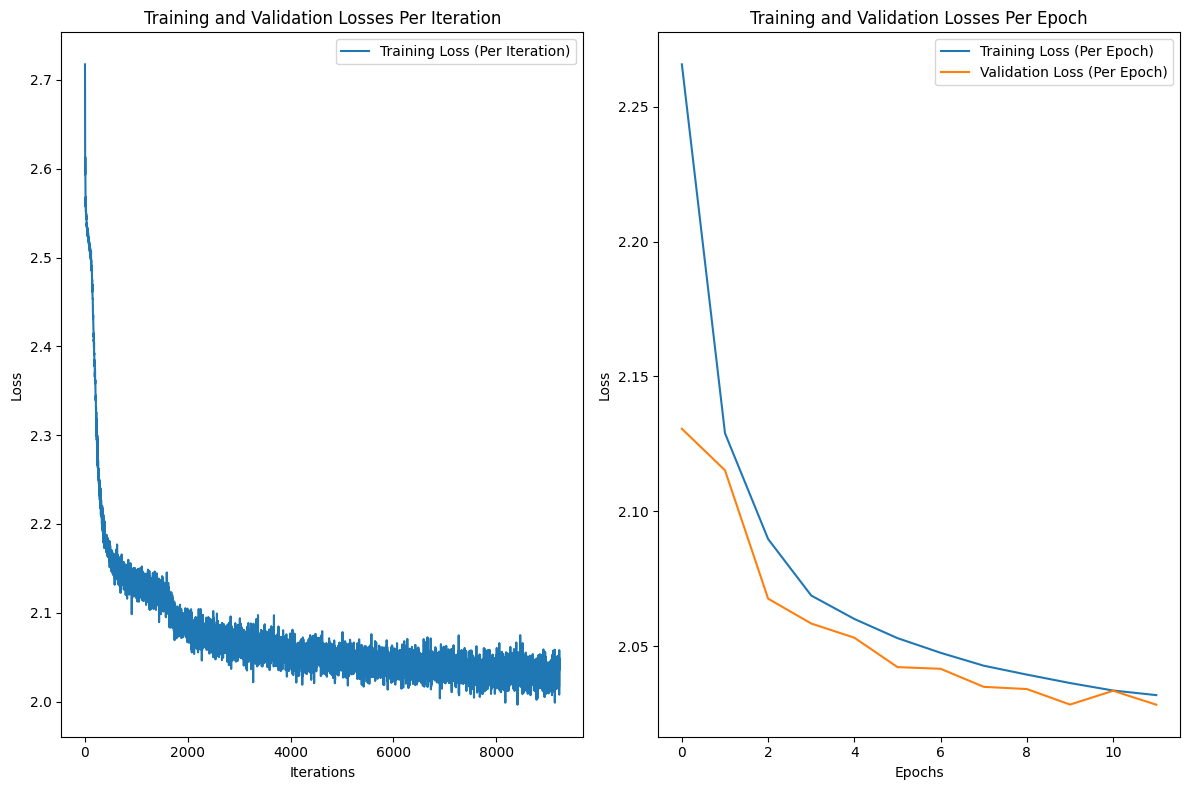

In [17]:
# Train and validate the model
trained_model = train_labrador(model, train_loader, test_loader, categorical_loss_fn, continuous_loss_fn, optimizer=optimizer, num_epochs=num_epochs, device=device, save_model=save_model, model_path=model_path, categorical_loss_weight=categorical_loss_weight, continuous_loss_weight=continuous_loss_weight, lr=lr)

In [18]:
# Save tokenizer
tokenizer.save_pretrained('labrador_tokenizer/')

### Test the model

In [19]:
dataset_test = LabradorDataset(continuous=lab_values_test, categorical=lab_ids_test, tokenizer=tokenizer, max_len=max_len, masking_prob=0)
# Dataloader:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

{'[MASK]': 8, '[NULL]': 9, '[PAD]': 10, 'Pot': 0, 'Bic': 1, 'Wbc': 2, 'Hgb': 3, 'Ure': 4, 'Plt': 5, 'Crt': 6, 'Sod': 7}


In [20]:
test_model(trained_model, test_loader, device, COLUMNS)

Evaluating Bic: 


  1%|          | 2/193 [00:00<00:46,  4.13it/s]

Preds: [0.5199097394943237, 0.5199097394943237, 0.4998743236064911, 0.4998743236064911, 0.515846848487854, 0.515846848487854, 0.4964250326156616, 0.4964250326156616, 0.5081642270088196, 0.5081642270088196, 0.5102041959762573, 0.5102041959762573, 0.4811607897281647, 0.4811607897281647, 0.4941401183605194, 0.4941401183605194, 0.503538966178894, 0.503538966178894, 0.4923554062843323, 0.4923554062843323, 0.509904146194458, 0.509904146194458, 0.4933140277862549, 0.4933140277862549, 0.509261965751648, 0.509261965751648, 0.5078343749046326, 0.5078343749046326, 0.4829939603805542, 0.4829939603805542, 0.503612756729126, 0.503612756729126, 0.5034627318382263, 0.5034627318382263, 0.4965680241584778, 0.4965680241584778, 0.5110271573066711, 0.5110271573066711, 0.5150675773620605, 0.5150675773620605, 0.5138959288597107, 0.5138959288597107, 0.5183953046798706, 0.5183953046798706, 0.5061400532722473, 0.5061400532722473, 0.5083429217338562, 0.5083429217338562, 0.4982563257217407, 0.4982563257217407, 0.

100%|██████████| 193/193 [00:22<00:00,  8.69it/s]


RMSE: 0.088
MAE: 0.068
R2: -0.034
-------------------
Evaluating Crt: 


  1%|          | 2/193 [00:00<00:44,  4.33it/s]

Preds: [0.02925717830657959, 0.02925717830657959, 0.07144441455602646, 0.07144441455602646, 0.04541824385523796, 0.04541824385523796, 0.03663645684719086, 0.03663645684719086, 0.026183627545833588, 0.026183627545833588, 0.019911840558052063, 0.019911840558052063, 0.04718661680817604, 0.04718661680817604, 0.041118741035461426, 0.041118741035461426, 0.007314751856029034, 0.007314751856029034, 0.05481380596756935, 0.05481380596756935, 0.0239640511572361, 0.0239640511572361, 0.0735074132680893, 0.0735074132680893, 0.03640613332390785, 0.03640613332390785, 0.01801561936736107, 0.01801561936736107, 0.10064639151096344, 0.10064639151096344, 0.04048655554652214, 0.04048655554652214, 0.014934702776372433, 0.014934702776372433, 0.04790743812918663, 0.04790743812918663, 0.02410895749926567, 0.02410895749926567, 0.025200553238391876, 0.025200553238391876, 0.0157594233751297, 0.0157594233751297, 0.027554064989089966, 0.027554064989089966, 0.02014431729912758, 0.02014431729912758, 0.0352715663611888

100%|██████████| 193/193 [00:22<00:00,  8.71it/s]


RMSE: 0.035
MAE: 0.017
R2: 0.350
-------------------
Evaluating Pot: 


  1%|          | 2/193 [00:00<00:42,  4.48it/s]

Preds: [0.22044511139392853, 0.22044511139392853, 0.2616729140281677, 0.2616729140281677, 0.23566749691963196, 0.23566749691963196, 0.21261855959892273, 0.21261855959892273, 0.19704551994800568, 0.19704551994800568, 0.20967882871627808, 0.20967882871627808, 0.24763891100883484, 0.24763891100883484, 0.22390402853488922, 0.22390402853488922, 0.20721158385276794, 0.20721158385276794, 0.24507030844688416, 0.24507030844688416, 0.20281058549880981, 0.20281058549880981, 0.250198096036911, 0.250198096036911, 0.23796218633651733, 0.23796218633651733, 0.21368350088596344, 0.21368350088596344, 0.2718707025051117, 0.2718707025051117, 0.22813445329666138, 0.22813445329666138, 0.21716849505901337, 0.21716849505901337, 0.24950945377349854, 0.24950945377349854, 0.2225164920091629, 0.2225164920091629, 0.219527006149292, 0.219527006149292, 0.20136238634586334, 0.20136238634586334, 0.21206508576869965, 0.21206508576869965, 0.21974407136440277, 0.21974407136440277, 0.2338210940361023, 0.2338210940361023, 

100%|██████████| 193/193 [00:22<00:00,  8.71it/s]


RMSE: 0.045
MAE: 0.034
R2: 0.064
-------------------
Evaluating Sod: 


  1%|          | 2/193 [00:00<00:42,  4.47it/s]

Preds: [0.5675368309020996, 0.5675368309020996, 0.5756875276565552, 0.5756875276565552, 0.5856471061706543, 0.5856471061706543, 0.5751395225524902, 0.5751395225524902, 0.562950611114502, 0.562950611114502, 0.5785624384880066, 0.5785624384880066, 0.5667083859443665, 0.5667083859443665, 0.5568801760673523, 0.5568801760673523, 0.5764809250831604, 0.5764809250831604, 0.5616756677627563, 0.5616756677627563, 0.5752514004707336, 0.5752514004707336, 0.5705903172492981, 0.5705903172492981, 0.5872586369514465, 0.5872586369514465, 0.5702962875366211, 0.5702962875366211, 0.5675030946731567, 0.5675030946731567, 0.5842602849006653, 0.5842602849006653, 0.58254075050354, 0.58254075050354, 0.5876598358154297, 0.5876598358154297, 0.5865579843521118, 0.5865579843521118, 0.5867622494697571, 0.5867622494697571, 0.5725328326225281, 0.5725328326225281, 0.5881794095039368, 0.5881794095039368, 0.5734387040138245, 0.5734387040138245, 0.5824528336524963, 0.5824528336524963, 0.5711326599121094, 0.5711326599121094

100%|██████████| 193/193 [00:22<00:00,  8.71it/s]


RMSE: 0.081
MAE: 0.067
R2: -0.031
-------------------
Evaluating Ure: 


  1%|          | 2/193 [00:00<00:43,  4.37it/s]

Preds: [0.08921782672405243, 0.08921782672405243, 0.274410605430603, 0.274410605430603, 0.10763910412788391, 0.10763910412788391, 0.08162839710712433, 0.08162839710712433, 0.06615474075078964, 0.06615474075078964, 0.059824518859386444, 0.059824518859386444, 0.24224822223186493, 0.24224822223186493, 0.12954702973365784, 0.12954702973365784, 0.04530923441052437, 0.04530923441052437, 0.1262013018131256, 0.1262013018131256, 0.06021043658256531, 0.06021043658256531, 0.14126744866371155, 0.14126744866371155, 0.07789142429828644, 0.07789142429828644, 0.06459822505712509, 0.06459822505712509, 0.23783738911151886, 0.23783738911151886, 0.09680724143981934, 0.09680724143981934, 0.054642025381326675, 0.054642025381326675, 0.23466742038726807, 0.23466742038726807, 0.06129705533385277, 0.06129705533385277, 0.07474721968173981, 0.07474721968173981, 0.08639878034591675, 0.08639878034591675, 0.039415840059518814, 0.039415840059518814, 0.060158781707286835, 0.060158781707286835, 0.12223610281944275, 0.1

100%|██████████| 193/193 [00:22<00:00,  8.71it/s]


RMSE: 0.057
MAE: 0.040
R2: 0.481
-------------------
Evaluating Hgb: 


  1%|          | 2/193 [00:00<00:43,  4.44it/s]

Preds: [0.4985544681549072, 0.4985544681549072, 0.49440309405326843, 0.49440309405326843, 0.5156109929084778, 0.5156109929084778, 0.5087327361106873, 0.5087327361106873, 0.5110023021697998, 0.5110023021697998, 0.509223461151123, 0.509223461151123, 0.507321834564209, 0.507321834564209, 0.5011227130889893, 0.5011227130889893, 0.5059996247291565, 0.5059996247291565, 0.4929990768432617, 0.4929990768432617, 0.5010435581207275, 0.5010435581207275, 0.5020864605903625, 0.5020864605903625, 0.49992966651916504, 0.49992966651916504, 0.5078463554382324, 0.5078463554382324, 0.4972471594810486, 0.4972471594810486, 0.522190511226654, 0.522190511226654, 0.5088759064674377, 0.5088759064674377, 0.516338586807251, 0.516338586807251, 0.510057806968689, 0.510057806968689, 0.5156018137931824, 0.5156018137931824, 0.5159973502159119, 0.5159973502159119, 0.5067988634109497, 0.5067988634109497, 0.5025331377983093, 0.5025331377983093, 0.5158030390739441, 0.5158030390739441, 0.50589919090271, 0.50589919090271, 0.

100%|██████████| 193/193 [00:22<00:00,  8.71it/s]


RMSE: 0.097
MAE: 0.082
R2: -0.126
-------------------
Evaluating Plt: 


  1%|          | 2/193 [00:00<00:41,  4.61it/s]

Preds: [0.08453872054815292, 0.08453872054815292, 0.06489881128072739, 0.06489881128072739, 0.0764254704117775, 0.0764254704117775, 0.074850894510746, 0.074850894510746, 0.08316648006439209, 0.08316648006439209, 0.07944446802139282, 0.07944446802139282, 0.07857776433229446, 0.07857776433229446, 0.07766920328140259, 0.07766920328140259, 0.098822221159935, 0.098822221159935, 0.09644792228937149, 0.09644792228937149, 0.0729084312915802, 0.0729084312915802, 0.08008366078138351, 0.08008366078138351, 0.07711374759674072, 0.07711374759674072, 0.08732599765062332, 0.08732599765062332, 0.08553213626146317, 0.08553213626146317, 0.08259698003530502, 0.08259698003530502, 0.08879823982715607, 0.08879823982715607, 0.08055056631565094, 0.08055056631565094, 0.08115580677986145, 0.08115580677986145, 0.08348087966442108, 0.08348087966442108, 0.08320590108633041, 0.08320590108633041, 0.07198692858219147, 0.07198692858219147, 0.09252656996250153, 0.09252656996250153, 0.0813840925693512, 0.0813840925693512

100%|██████████| 193/193 [00:22<00:00,  8.71it/s]


RMSE: 0.059
MAE: 0.041
R2: -0.028
-------------------
Evaluating Wbc: 


  1%|          | 2/193 [00:00<00:40,  4.77it/s]

Preds: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

100%|██████████| 193/193 [00:22<00:00,  8.73it/s]

RMSE: 0.021
MAE: 0.015
R2: -1.286
-------------------


{'Bic': {'rmse': [0.08836586391959039],
  'mae': [0.06819945772707632],
  'r2': [-0.03409206492373129]},
 'Crt': {'rmse': [0.034501800985809385],
  'mae': [0.016818272003856022],
  'r2': [0.3503332189205106]},
 'Pot': {'rmse': [0.04483872781450302],
  'mae': [0.03430451512931403],
  'r2': [0.06408975293587649]},
 'Sod': {'rmse': [0.08118632893168402],
  'mae': [0.06713467625087137],
  'r2': [-0.03068846916937118]},
 'Ure': {'rmse': [0.057187864346068366],
  'mae': [0.03990834204221406],
  'r2': [0.4810388497763527]},
 'Hgb': {'rmse': [0.09746799907879952],
  'mae': [0.08163082364745021],
  'r2': [-0.12586322298650043]},
 'Plt': {'rmse': [0.05896498478938408],
  'mae': [0.04128585932426881],
  'r2': [-0.02759690214234789]},
 'Wbc': {'rmse': [0.020664267324248805],
  'mae': [0.015498816401177304],
  'r2': [-1.2859478917097626]}}

##### Push to HuggingFace (Optional)

In [ ]:
from huggingface_hub import notebook_login
from huggingface_hub import upload_file
from huggingface_hub import HfApi, HfFolder

notebook_login()

api = HfApi()

model_path = "labrador_model.pth"
tokenizer_config_path = "labrador_tokenizer/tokenizer_config.json"

repo_id = "dsrestrepo/Labrador_pt"
repo_url = f"https://huggingface.co/{repo_id}"

# Upload the model
upload_file(path_or_fileobj=model_path, path_in_repo="labrador_model.pth", repo_id=repo_id, token=HfFolder.get_token())

# Upload the tokenizer configuration
upload_file(path_or_fileobj=tokenizer_config_path, path_in_repo="tokenizer_config.json", repo_id=repo_id, token=HfFolder.get_token())


labrador_model.pth:   0%|          | 0.00/165M [00:00<?, ?B/s]

'https://huggingface.co/dsrestrepo/Labrador_pt/blob/main/tokenizer_config.json'